In [1]:
!conda install -y -c anaconda psycopg2 sqlalchemy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [63]:
!pip install  xgboost

    100% |████████████████████████████████| 481kB 2.6MB/s eta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/44/75/71/94198575ab2a2946397287601c0632d196bc56a7ff4b985aba
Successfully built xgboost
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install ipython-sql

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline

PARTNER_ID="35"

In [3]:
#Extra functions helpers to make plots

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

## Read Data

In [4]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']

connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




In [5]:
# build the pandas dataframe with the bid information
query="select * from ml_prep.offer_load_eligibility_last_event_by_session_usd_with_offer_undersampled_prod_" + PARTNER_ID
original_df = pd.read_sql_query(query, con)
original_df.head()

event_id            event_time  \
0  e180e4e8-4c0d-4267-8aa3-2e4c108fb6f6  2018-02-18T04:33:43Z   
1  9b4841d7-a1f2-4f3d-95f1-ccda128b9c1c  2017-10-05T06:40:53Z   
2  7fb7f956-2704-4319-8bd6-099099fab7df  2018-01-04T04:55:36Z   
3  82e2557e-e739-40d9-90ff-85fb7f8c85fb  2017-11-13T09:08:01Z   
4  5f24d7ea-3f7f-4036-a3cf-b6858e2b6d15  2017-11-21T23:15:20Z   

                           request_id  partner_id origin destination  \
0  HDjW1n29d3MlNkXTlw4fHtYsffUAZ3y87d          35    SYD         MEL   
1  xr9X8ifU9eIfzZlJmSL25yqj2k2aqnScOJ          35    PER         SYD   
2  j5eRDB4cgrZGD16xJvJ7HuDw0QAErWpegn          35    MKY         BNE   
3  YAbti806wDPq0qT4I8tG0regT6G38b9wIN          35    PER         MEL   
4  WTILgnazu4926ipWRQUtxQNCxvsXZD3GKt          35    SYD         ADL   

   flight_number departure_date departure_time currency     ...      \
0            842     2018-02-24          13:00      AUD     ...       
1            570     2017-10-08          22:55      AUD     ...       
2            608     2018-02-08          11:00      AUD     ...       
3            676     2017-11-17          05:20      AUD     ...       
4            444     2017-11-23          20:15      AUD     ...       

  slider_step duration  distance  distance_unit equipment slider_max_usd  \
0           5       95       439             mi       73H          252.0   
1           5      260      2039             mi       73H          467.0   
2           5       85       497             mi       73H          274.0   
3           5      215      1680             mi       332          532.0   
4           5      130       724             mi       73H          265.0   

  slider_min_usd slider_start_usd offer_amount customer_id  
0          110.0            198.0     113.0591   4190706.0  
1          303.0            386.0     358.3891   3721242.0  
2           75.0            177.0      74.6985   3685810.0  
3          206.0            353.0     209.4122   3546763.0  
4           84.0            164.0      87.2284   3881342.0  

[5 rows x 33 columns]

In [6]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 33 columns):
event_id                              282354 non-null object
event_time                            282354 non-null object
request_id                            282354 non-null object
partner_id                            282354 non-null int64
origin                                282354 non-null object
destination                           282354 non-null object
flight_number                         282354 non-null int64
departure_date                        282354 non-null object
departure_time                        282354 non-null object
currency                              282354 non-null object
pnr                                   282354 non-null object
language                              282354 non-null object
pax                                   282354 non-null int64
eligibility                           282354 non-null bool
point_of_sale                         28

In [7]:
#drop non relevant fields
df = original_df.drop(['distance_unit', 'request_id', 'event_id', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', "instant_upgrade_eligibility"
        ], axis=1)

In [8]:
# add has_bid based on the offer_amount column

df['has_bid'] = df['offer_amount'].notnull()
df.tail()

event_time  partner_id origin destination  flight_number  \
282349  2017-09-18T02:56:58Z          35    BNE         NAN            175   
282350  2017-09-18T00:34:48Z          35    BNE         DPS             43   
282351  2017-09-13T08:31:32Z          35    SYD         ZQN            162   
282352  2017-11-10T06:28:38Z          35    CNS         SYD           1408   
282353  2018-03-13T05:23:57Z          35    WLG         BNE            100   

       departure_date departure_time currency language  pax   ...    \
282349     2017-09-25          09:25      AUD       en    2   ...     
282350     2017-09-21          10:05      AUD       en    4   ...     
282351     2017-11-07          10:30      AUD       en    2   ...     
282352     2017-11-27          05:10      USD       en    1   ...     
282353     2018-03-26          07:00      AUD       EN    1   ...     

             upgrade_type duration distance equipment slider_max_usd  \
282349  BUSINESS_DOMESTIC      210     1689       73H          358.0   
282350  BUSINESS_DOMESTIC      400     2791       73H          477.0   
282351  BUSINESS_DOMESTIC      180     1206       73H          478.0   
282352  BUSINESS_DOMESTIC      185     1227       73H          383.0   
282353  BUSINESS_DOMESTIC      240     1561       73H          314.0   

       slider_min_usd slider_start_usd  offer_amount  customer_id has_bid  
282349          143.0            294.0      159.4214    3666008.0    True  
282350          230.0            395.0      278.9876    3665716.0    True  
282351          151.0            374.0      159.5947    3650926.0    True  
282352          110.0            215.0      175.0000    3842722.0    True  
282353          101.0            251.0      102.1794    3533559.0    True  

[5 rows x 26 columns]

In [9]:
#What is the distribution of numerical feature values across the samples?
df.describe()

partner_id  flight_number            pax       duration       distance  \
count    282354.0  282354.000000  282354.000000  282354.000000  282354.000000   
mean         35.0     635.342620       1.599875     244.238541    1825.438921   
std           0.0     475.124699       0.867205     237.178111    2161.982361   
min          35.0       1.000000       1.000000      50.000000     147.000000   
25%          35.0     228.000000       1.000000      95.000000     465.000000   
50%          35.0     562.000000       1.000000     145.000000     867.000000   
75%          35.0     916.000000       2.000000     260.000000    1972.000000   
max          35.0    1898.000000       5.000000     950.000000    7936.000000   

       slider_max_usd  slider_min_usd  slider_start_usd  offer_amount  \
count   282354.000000   282354.000000     282354.000000  56471.000000   
mean       580.985603      233.391849        452.464389    194.889439   
std        841.365366      372.216045        701.001238    216.869817   
min        138.000000       41.000000         75.000000     45.523100   
25%        243.000000       91.000000        176.000000     98.942900   
50%        308.000000      114.000000        224.000000    129.701600   
75%        456.000000      226.000000        362.000000    220.785600   
max       5520.000000     3111.000000       4798.000000   4235.000000   

        customer_id  
count  5.647100e+04  
mean   3.691840e+06  
std    5.943228e+05  
min    1.851429e+06  
25%    3.657488e+06  
50%    3.865622e+06  
75%    4.082716e+06  
max    4.315807e+06

In [10]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_time  origin destination departure_date  \
count                 282354  282354      282354         282354   
unique                213539      44          44            510   
top     2018-01-04T03:49:05Z     MEL         MEL     2017-12-22   
freq                       7   57985       57920           2238   

       departure_time currency language point_of_sale    channel_source  \
count          282354   282354   282354        282354            282354   
unique            227       14        3             3              6065   
top             11:15      AUD       en            GS  PRE_TRAVEL_EMAIL   
freq             5593   267691   159919        204485             74243   

       carrier_code fare_class from_cabin       upgrade_type equipment  
count        282354     282354     282354             282354    282354  
unique            1         16          2                  4         6  
top              VA          T    ECONOMY  BUSINESS_DOMESTIC       73H  
freq         282354      81324     279248             220629    214583

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 26 columns):
event_time          282354 non-null object
partner_id          282354 non-null int64
origin              282354 non-null object
destination         282354 non-null object
flight_number       282354 non-null int64
departure_date      282354 non-null object
departure_time      282354 non-null object
currency            282354 non-null object
language            282354 non-null object
pax                 282354 non-null int64
eligibility         282354 non-null bool
point_of_sale       282354 non-null object
channel_source      282354 non-null object
carrier_code        282354 non-null object
fare_class          282354 non-null object
from_cabin          282354 non-null object
upgrade_type        282354 non-null object
duration            282354 non-null int64
distance            282354 non-null int64
equipment           282354 non-null object
slider_max_usd      282354 non-null 

## Some visual analysis

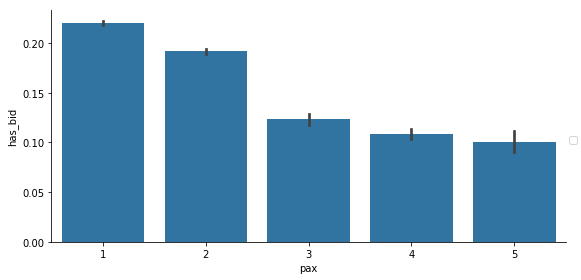

In [12]:
plot_categories( df , cat = 'pax' , target = 'has_bid' )

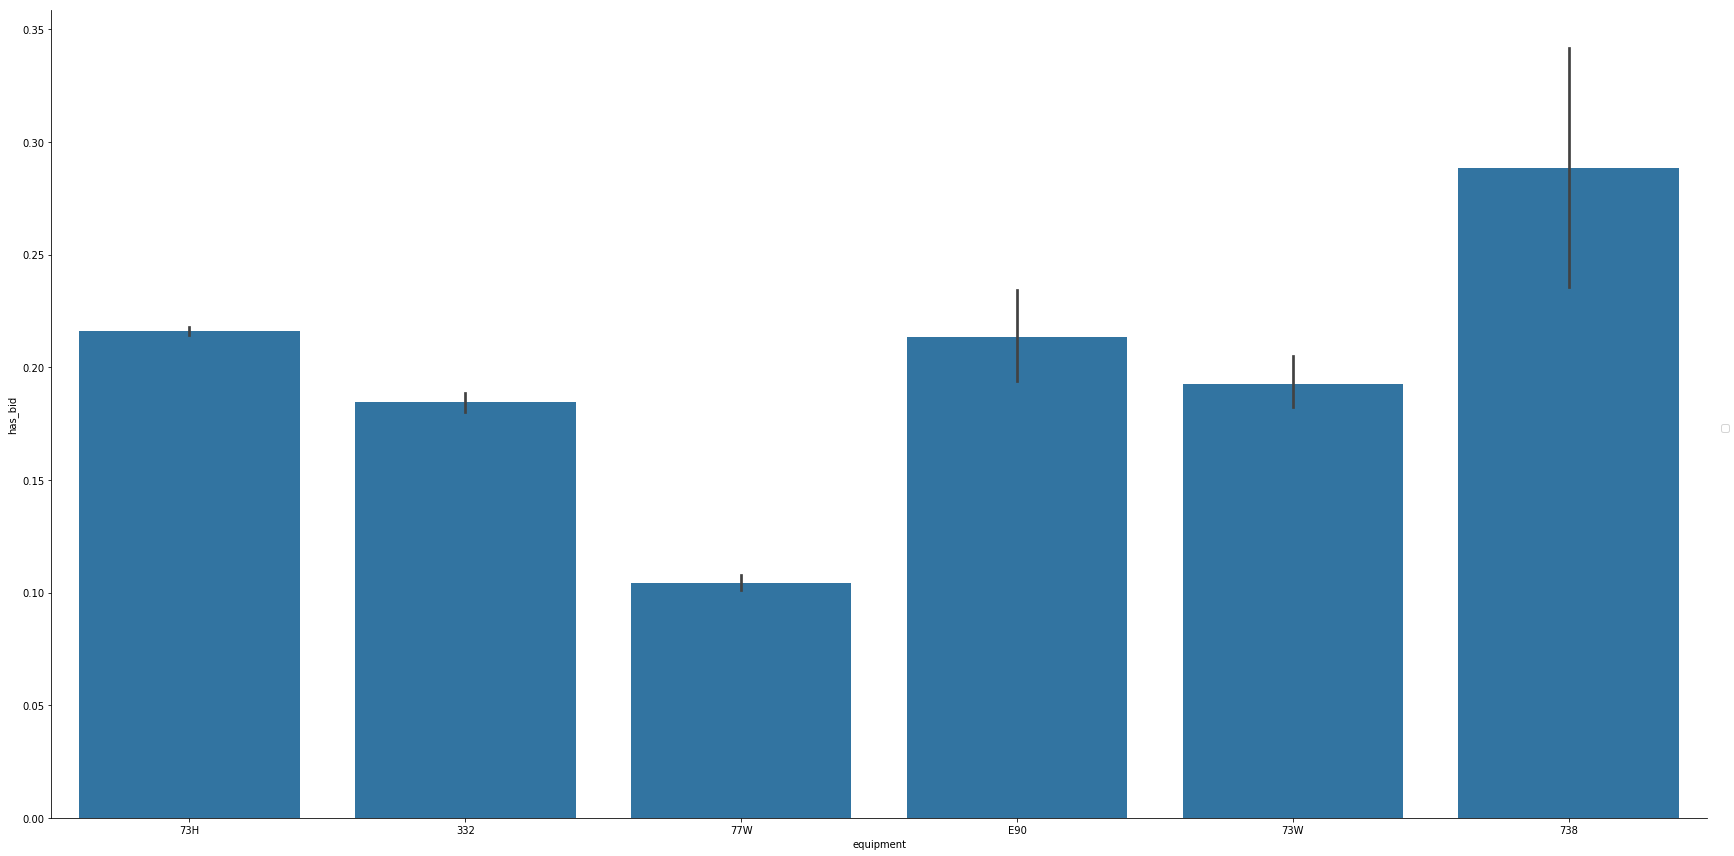

In [13]:
plot_categories( df , cat = 'equipment' , target = 'has_bid',size=12, aspect=2 )

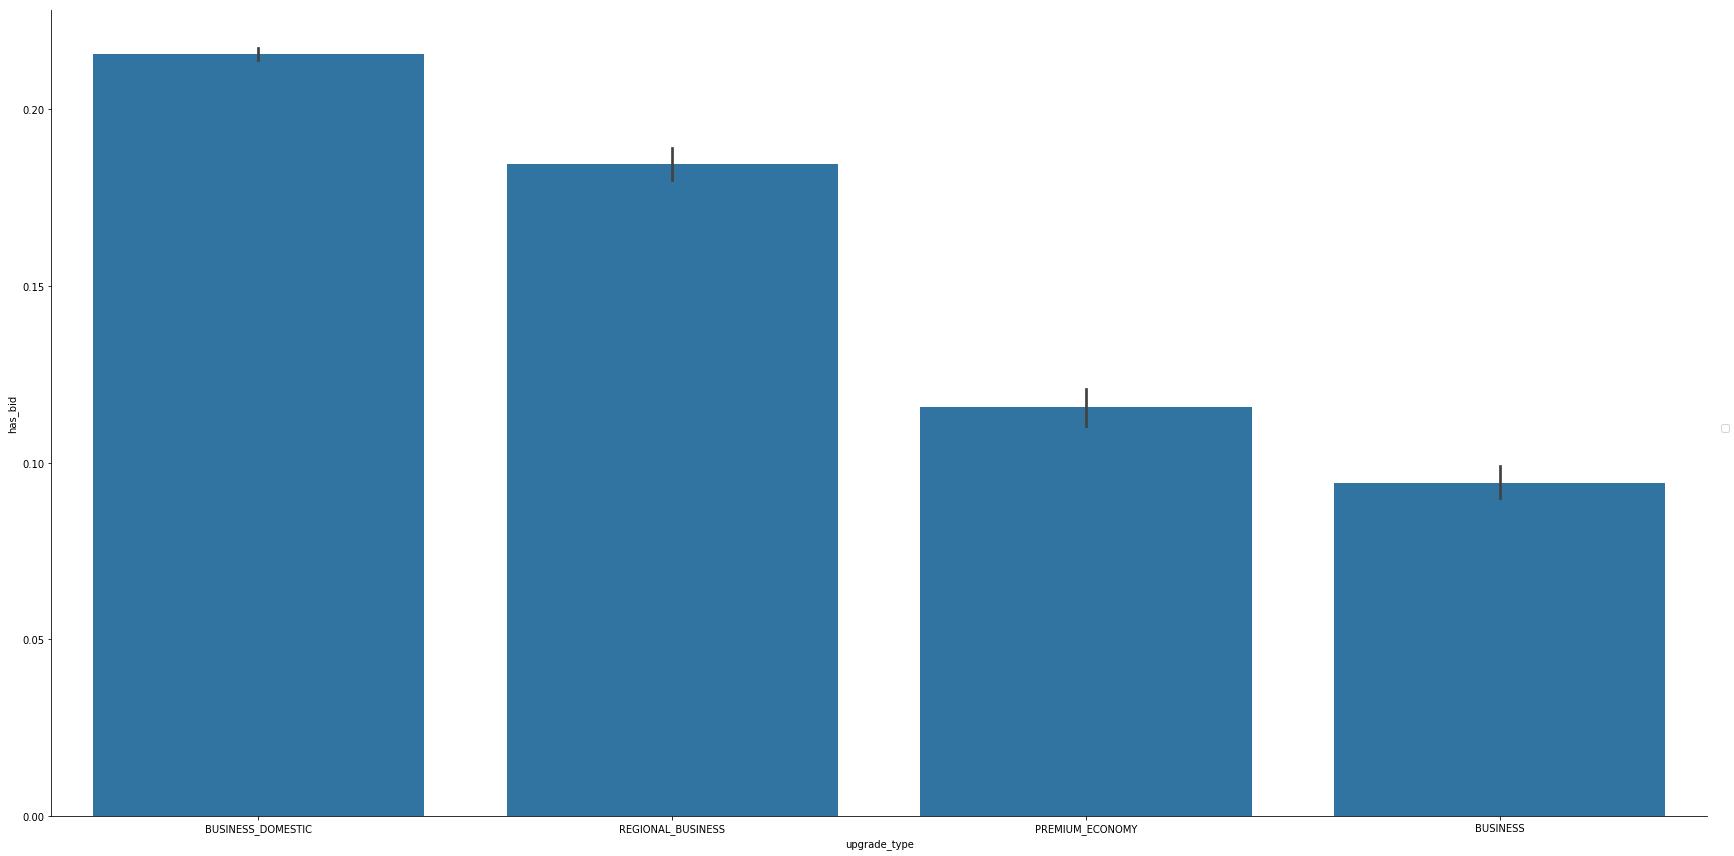

In [14]:
plot_categories( df , cat = 'upgrade_type' , target = 'has_bid',size=12, aspect=2 )

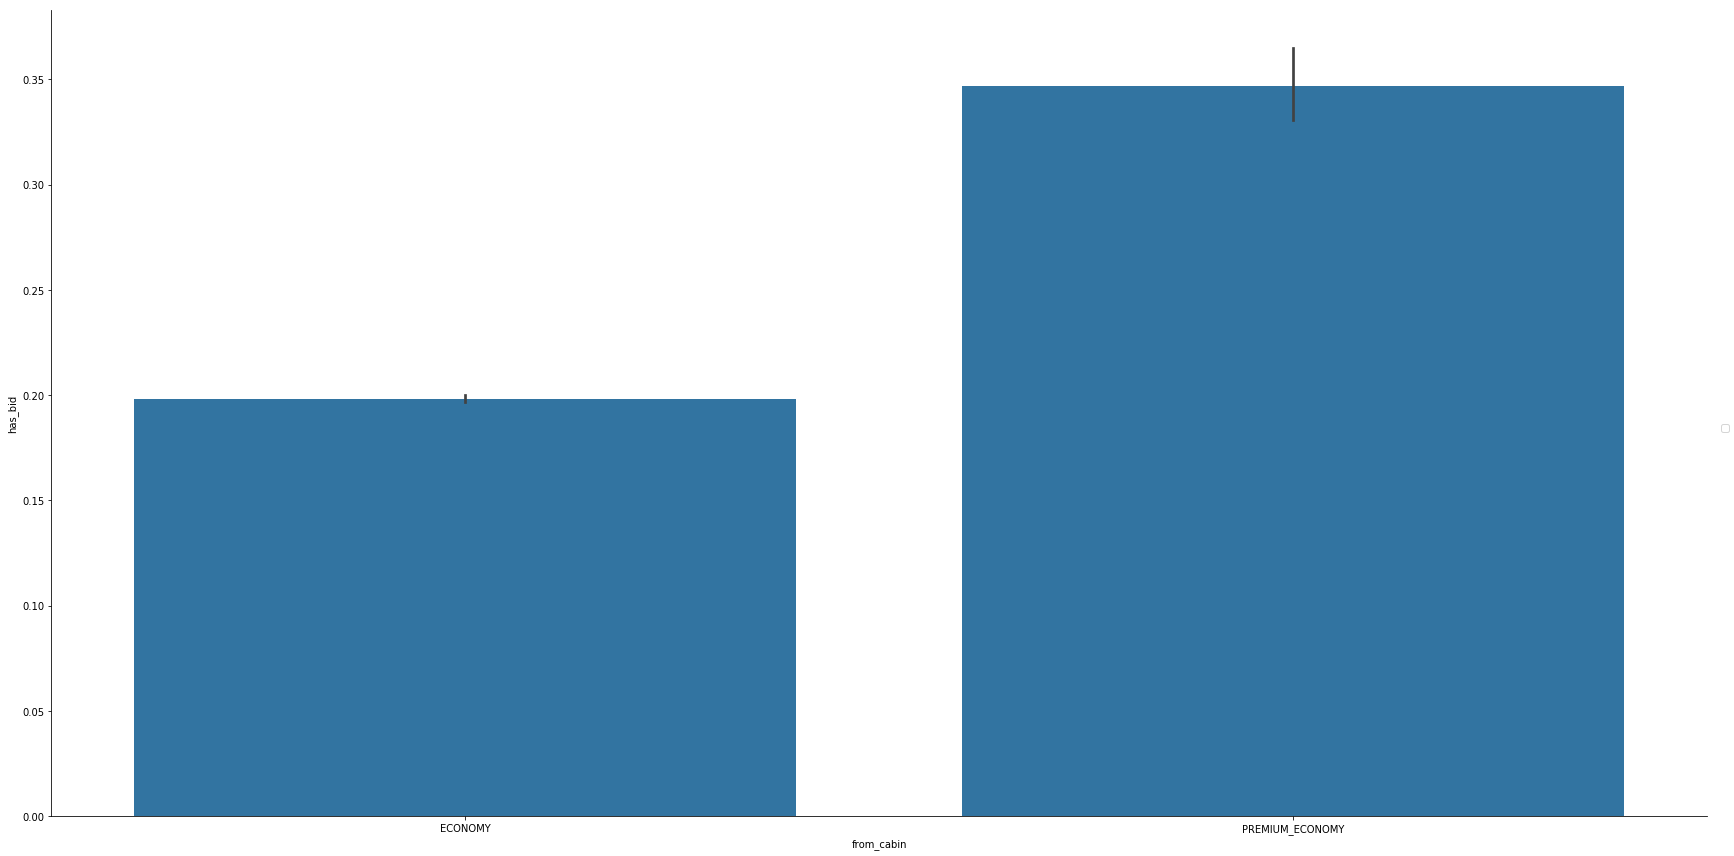

In [15]:
plot_categories( df , cat = 'from_cabin' , target = 'has_bid',size=12, aspect=2 )

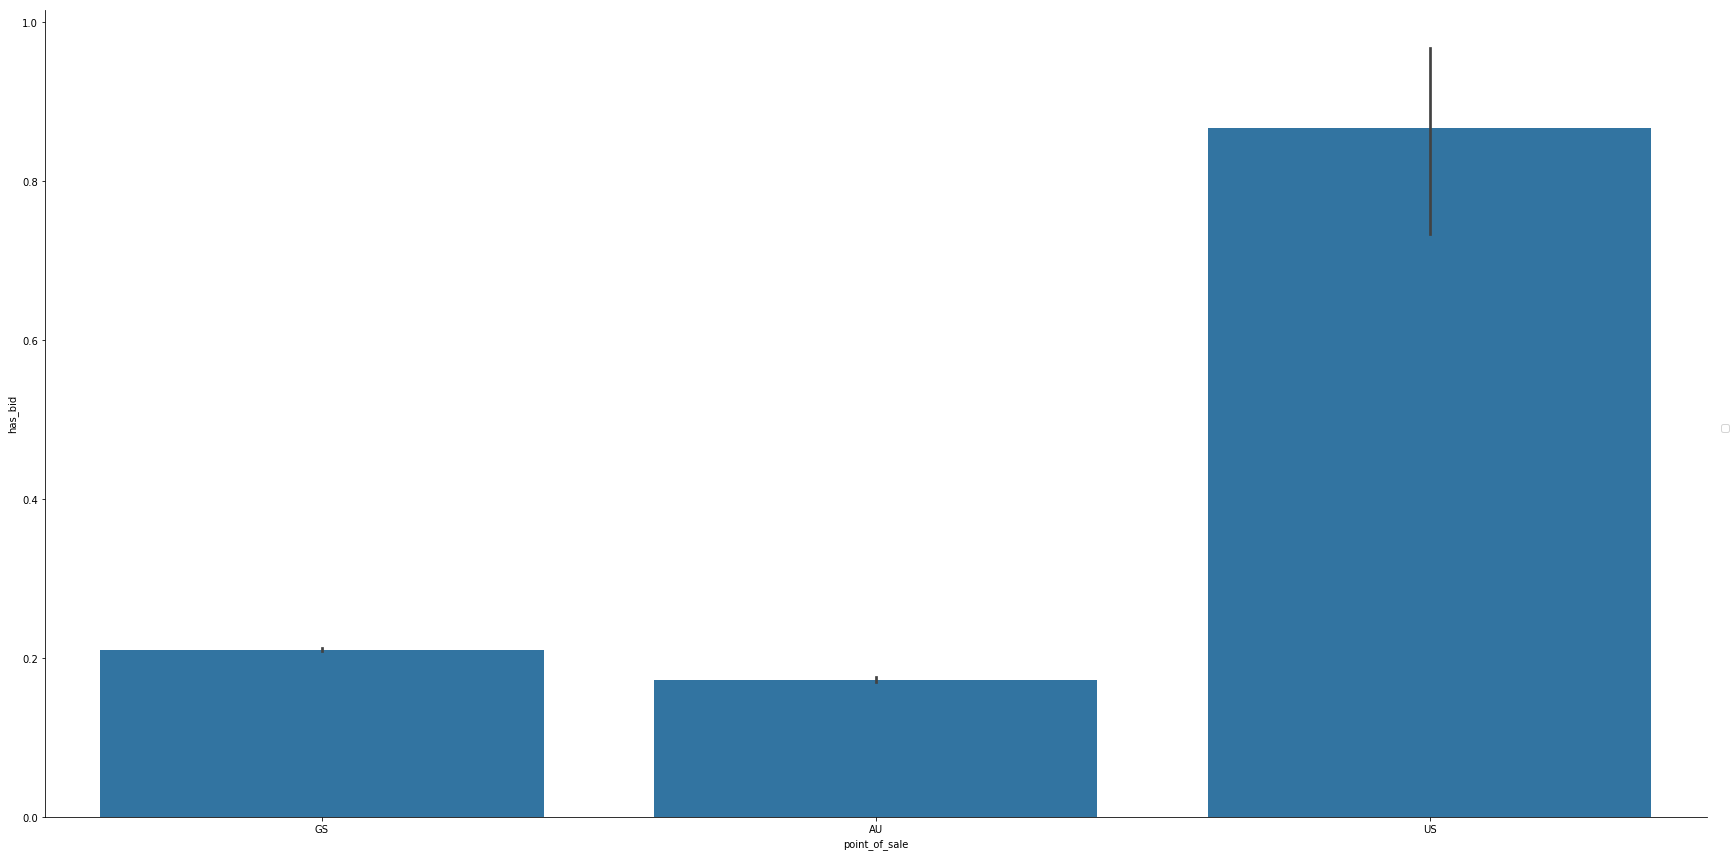

In [16]:
plot_categories( df , cat = 'point_of_sale' , target = 'has_bid',size=12, aspect=2 )

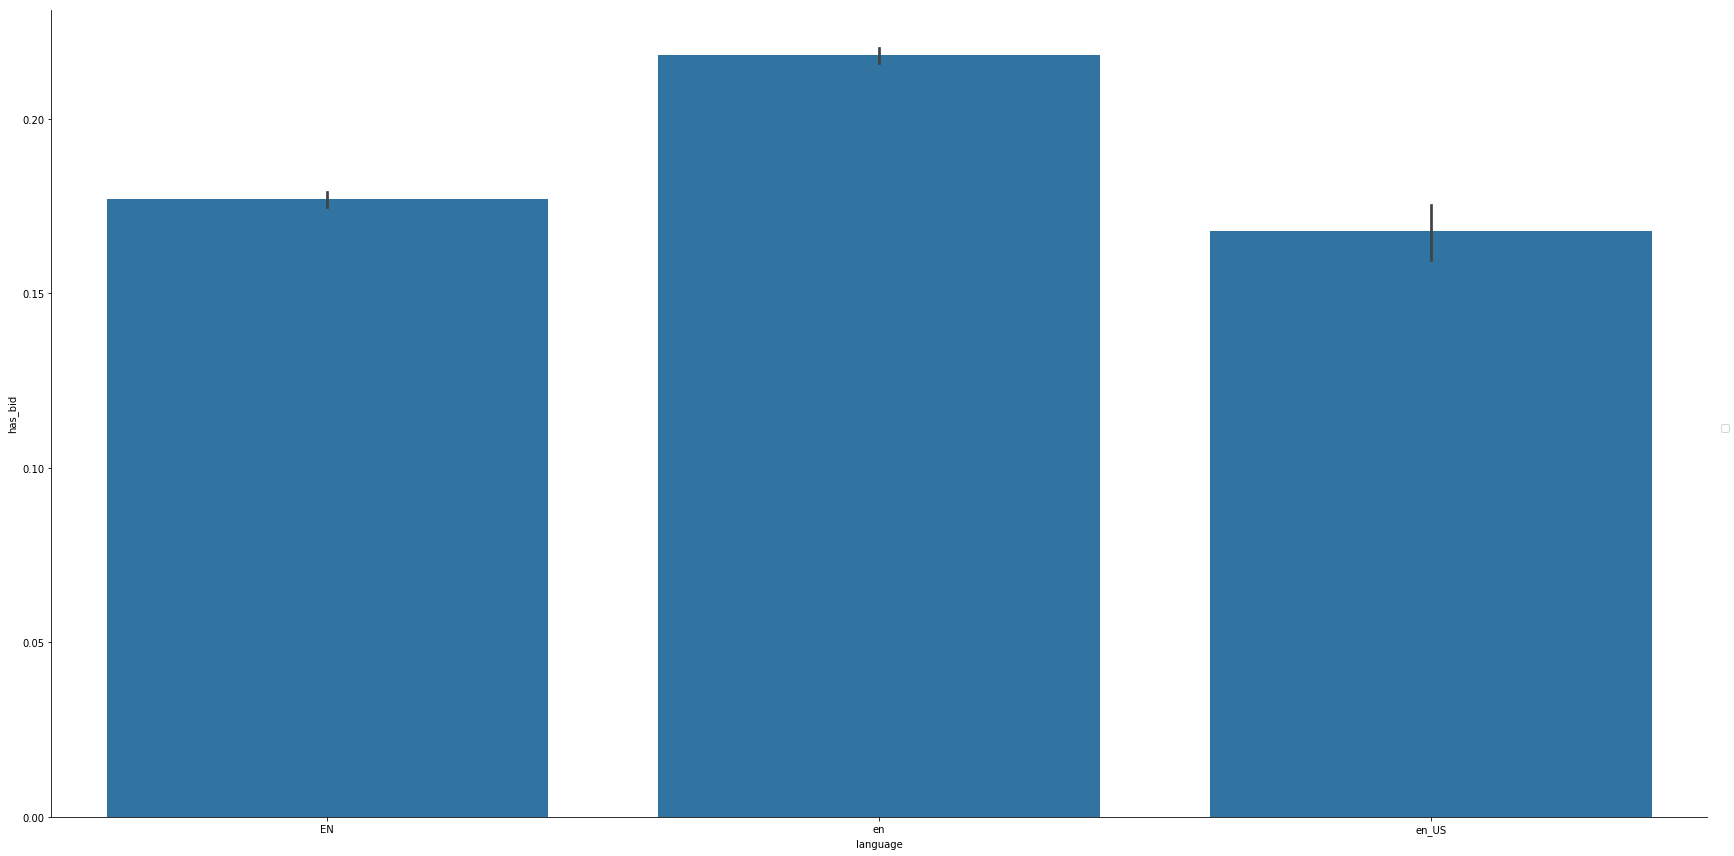

In [17]:
plot_categories( df , cat = 'language' , target = 'has_bid',size=12, aspect=2 )

## Wrangle Data

### Removing features fill nans

In [18]:
df_nonNas = df.copy()

#drop minutes from departure_time
df_nonNas["departure_time"] = df_nonNas.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)

#fill equipment unknowns
df_nonNas['equipment'] = df_nonNas['equipment'].fillna("unknown")
df_nonNas['distance'] = df_nonNas['distance'].fillna(0)
df_nonNas['duration'] = df_nonNas['duration'].fillna(0)

df_nonNas['pax'] = df_nonNas['pax'].fillna(1)

#Convert float64 to float32
for column in ["pax", "slider_max_usd", "slider_min_usd", "slider_start_usd", "distance", "duration", "flight_number"]:
    df_nonNas[column] = df_nonNas[column].astype(np.float32)


train_df = df_nonNas.drop(['customer_id', 'offer_amount', 'carrier_code', 'partner_id'],axis = 1).copy()


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 22 columns):
event_time          282354 non-null object
origin              282354 non-null object
destination         282354 non-null object
flight_number       282354 non-null float32
departure_date      282354 non-null object
departure_time      282354 non-null object
currency            282354 non-null object
language            282354 non-null object
pax                 282354 non-null float32
eligibility         282354 non-null bool
point_of_sale       282354 non-null object
channel_source      282354 non-null object
fare_class          282354 non-null object
from_cabin          282354 non-null object
upgrade_type        282354 non-null object
duration            282354 non-null float32
distance            282354 non-null float32
equipment           282354 non-null object
slider_max_usd      282354 non-null float32
slider_min_usd      282354 non-null float32
slider_start_usd    28235

## Add features

In [20]:
#add days before departure and destination_origin
train_df2 = train_df.copy()

train_df2["event_time"] = train_df2["event_time"].astype('datetime64[ns]')
train_df2["event_time"] = train_df2["event_time"].apply(lambda x: x.date() )
train_df2["departure_date"] = train_df2["departure_date"].astype('datetime64[ns]')
train_df2["departure_date"] = train_df2["departure_date"].apply(lambda x: x.date() )
train_df2["days_before_departure"] = train_df2["departure_date"] - train_df2["event_time"]
train_df2["days_before_departure"] = train_df2["days_before_departure"].apply(lambda x: x.days)
train_df2["destination_origin"] = train_df2["destination"]  + "-" + train_df2["origin"]

train_df2.drop(['event_time', 'departure_date', 'departure_time', 'eligibility'], axis=1, inplace=True)


In [21]:
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 20 columns):
origin                   282354 non-null object
destination              282354 non-null object
flight_number            282354 non-null float32
currency                 282354 non-null object
language                 282354 non-null object
pax                      282354 non-null float32
point_of_sale            282354 non-null object
channel_source           282354 non-null object
fare_class               282354 non-null object
from_cabin               282354 non-null object
upgrade_type             282354 non-null object
duration                 282354 non-null float32
distance                 282354 non-null float32
equipment                282354 non-null object
slider_max_usd           282354 non-null float32
slider_min_usd           282354 non-null float32
slider_start_usd         282354 non-null float32
has_bid                  282354 non-null bool
days_before_departur

### Factorize categorical features

In [124]:
#we can factorize all values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def factorize_df(df, columns):
    train_df_fact = df.copy()
    train_df_fact["channel_source"] = df[["channel_source"]].apply(lambda x: pd.factorize(x)[0])
    for column in columns:
        le.fit(train_df_fact[column])
        train_df_fact[column] = le.transform(train_df_fact[column])
    return train_df_fact
 

In [125]:
#factorize the categorical fields
columns_cat = [ "origin", "destination", "flight_number", "currency", "language", "point_of_sale", "fare_class", "from_cabin", "upgrade_type", "equipment", "destination_origin"]  
train_df_fact = factorize_df(train_df2, columns_cat) 

In [126]:
train_df_fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 20 columns):
origin                   282354 non-null int64
destination              282354 non-null int64
flight_number            282354 non-null int64
currency                 282354 non-null int64
language                 282354 non-null int64
pax                      282354 non-null float32
point_of_sale            282354 non-null int64
channel_source           282354 non-null int64
fare_class               282354 non-null int64
from_cabin               282354 non-null int64
upgrade_type             282354 non-null int64
duration                 282354 non-null float32
distance                 282354 non-null float32
equipment                282354 non-null int64
slider_max_usd           282354 non-null float32
slider_min_usd           282354 non-null float32
slider_start_usd         282354 non-null float32
has_bid                  282354 non-null bool
days_before_departure    282354 

In [121]:
train_df2.head()

origin destination  flight_number currency language  pax point_of_sale  \
0    SYD         MEL          842.0      AUD       EN  2.0            GS   
1    PER         SYD          570.0      AUD       EN  1.0            GS   
2    MKY         BNE          608.0      AUD       en  1.0            GS   
3    PER         MEL          676.0      AUD       EN  1.0            GS   
4    SYD         ADL          444.0      AUD       EN  2.0            GS   

                             channel_source fare_class from_cabin  \
0  PRE_TRAVEL_EMAIL+ABANDONED_OFFER_PROCESS          T    ECONOMY   
1                          PRE_TRAVEL_EMAIL          T    ECONOMY   
2                         CONFIRMATION_PAGE          T    ECONOMY   
3                              CHASER_EMAIL          T    ECONOMY   
4                          PRE_TRAVEL_EMAIL          T    ECONOMY   

        upgrade_type  duration  distance equipment  slider_max_usd  \
0  BUSINESS_DOMESTIC      95.0     439.0       73H           252.0   
1  BUSINESS_DOMESTIC     260.0    2039.0       73H           467.0   
2  BUSINESS_DOMESTIC      85.0     497.0       73H           274.0   
3  REGIONAL_BUSINESS     215.0    1680.0       332           532.0   
4  BUSINESS_DOMESTIC     130.0     724.0       73H           265.0   

   slider_min_usd  slider_start_usd  has_bid  days_before_departure  \
0           110.0             198.0     True                      6   
1           303.0             386.0     True                      3   
2            75.0             177.0     True                     35   
3           206.0             353.0     True                      4   
4            84.0             164.0     True                      2   

  destination_origin  
0            MEL-SYD  
1            SYD-PER  
2            BNE-MKY  
3            MEL-PER  
4            ADL-SYD

## Create a models and evaluations

In [25]:
#Function utils

random_forest = RandomForestClassifier(n_estimators=100)
from xgboost import XGBClassifier
boost = XGBClassifier()

def do_train(df_to_train, n_splits = 2, model = boost):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    accuracys = []
    aucs = []
    for i, (train_index, test_index) in enumerate(kf.split(df_to_train)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = x.iloc[train_index,:].copy(), x.iloc[test_index,:].copy()
        #print( "\nFold ", i+1)
        model.fit(X_train, y_train)
        acc_random_forest = round(model.score(X_valid, y_valid) * 100, 2)
        accuracys.append(acc_random_forest)
        Y_test_pred = model.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_valid.astype(int), Y_test_pred)
        aucs.append(metrics.auc(fpr, tpr))
    print ("ACCURACY = {}".format(reduce(lambda x, y: x + y, accuracys) / len(accuracys)))  
    print ("AUC = {}".format(reduce(lambda x, y: x + y, aucs) / len(aucs)))  


In [127]:
do_train(train_df_fact)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7014619891567024


### We already know the channel_source is a very important feature. Lets, try to figure out which of the features have more impact, training the model without them 

In [27]:
from itertools import combinations 
def combs(x):
    return [c for i in range(len(x)+1) for c in combinations(x,i)]

In [28]:
features = list(train_df_fact.drop(["has_bid", "channel_source"], axis = 1).columns.values)
featureCombinations = combs(features)
featureCombinations = list(map(lambda x: list(x), list(filter(lambda x: len(x) < 3 and len(x) > 0, featureCombinations))))

In [29]:
for featureSet in featureCombinations:
    print ("Feature removed {}".format(featureSet))
    do_train(train_df_fact.drop(featureSet,axis=1))

Feature removed ['origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7017178333767717
Feature removed ['destination']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7014619891567024
Feature removed ['flight_number']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7011469545513233
Feature removed ['currency']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7014003790075358
Feature removed ['language']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7017569753518897
Feature removed ['pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.6963203138806464
Feature removed ['point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6957164584483495
Feature removed ['fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.785
AUC = 0.698800861831923
Feature removed ['from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7007177178699976
Feature removed ['upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.701588520645111
Feature removed ['duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7013613221810546
Feature removed ['distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7014566447534849
Feature removed ['equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.7014256674630674
Feature removed ['slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.701936322569868
Feature removed ['slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.6997097386189172
Feature removed ['slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7007502773943228
Feature removed ['days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.74000000000001
AUC = 0.6967688534586375
Feature removed ['destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7018110269567122
Feature removed ['origin', 'destination']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7017178333767717
Feature removed ['origin', 'flight_number']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7009119737630254
Feature removed ['origin', 'currency']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7017850219302608
Feature removed ['origin', 'language']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78
AUC = 0.7018068911355524
Feature removed ['origin', 'pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.6964478760343242
Feature removed ['origin', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75
AUC = 0.6959617977869227
Feature removed ['origin', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78999999999999
AUC = 0.6986409651691544
Feature removed ['origin', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7013189675387244
Feature removed ['origin', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7019792176881172
Feature removed ['origin', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.7013918970810678
Feature removed ['origin', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7015344285791107
Feature removed ['origin', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.701712094042521
Feature removed ['origin', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.702168740826457
Feature removed ['origin', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.6989037555861821
Feature removed ['origin', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7013986770344638
Feature removed ['origin', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.74000000000001
AUC = 0.6967294922741796
Feature removed ['origin', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7021053736294038
Feature removed ['destination', 'flight_number']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7011469545513233
Feature removed ['destination', 'currency']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7014003790075358
Feature removed ['destination', 'language']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7017567597484047
Feature removed ['destination', 'pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.6963203138806464
Feature removed ['destination', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6957162006035409
Feature removed ['destination', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.785
AUC = 0.698800861831923
Feature removed ['destination', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7007177178699976
Feature removed ['destination', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.701588520645111
Feature removed ['destination', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7013613221810546
Feature removed ['destination', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7014566447534849
Feature removed ['destination', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.7014256674630674
Feature removed ['destination', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7019359067519304
Feature removed ['destination', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.6997097386189172
Feature removed ['destination', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7007501147102657
Feature removed ['destination', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.74000000000001
AUC = 0.6967688534586375
Feature removed ['destination', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.7019595425829972
Feature removed ['flight_number', 'currency']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7013715238305802
Feature removed ['flight_number', 'language']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78
AUC = 0.7018664450437769
Feature removed ['flight_number', 'pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.6955890063866481
Feature removed ['flight_number', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6949931150060886
Feature removed ['flight_number', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.785
AUC = 0.6982596476150034
Feature removed ['flight_number', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7009752001770362
Feature removed ['flight_number', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7011569138463212
Feature removed ['flight_number', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.7012725485487983
Feature removed ['flight_number', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.700347741462243
Feature removed ['flight_number', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7010874416296895
Feature removed ['flight_number', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78
AUC = 0.7008814567782362
Feature removed ['flight_number', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.6976624595393353
Feature removed ['flight_number', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7004539509308274
Feature removed ['flight_number', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.6967097479415862
Feature removed ['flight_number', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7012036966619635
Feature removed ['currency', 'language']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7018338396938782
Feature removed ['currency', 'pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.6962611458064871
Feature removed ['currency', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75
AUC = 0.6956503509840277
Feature removed ['currency', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78
AUC = 0.6982669387942325
Feature removed ['currency', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.7009502188539056
Feature removed ['currency', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7016950792142691
Feature removed ['currency', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7016819935392347
Feature removed ['currency', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78
AUC = 0.7012103931774735
Feature removed ['currency', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.7018051689027913
Feature removed ['currency', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7020546802180699
Feature removed ['currency', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75
AUC = 0.6993800699226995
Feature removed ['currency', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77000000000001
AUC = 0.7018044635139105
Feature removed ['currency', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75
AUC = 0.6970402197887507
Feature removed ['currency', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7014855234839091
Feature removed ['language', 'pax']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.6969480157109873
Feature removed ['language', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77000000000001
AUC = 0.6965865322251248
Feature removed ['language', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.6996332504669065
Feature removed ['language', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.7006734651545792
Feature removed ['language', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78
AUC = 0.7016772838223493
Feature removed ['language', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.7017280956092125
Feature removed ['language', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78999999999999
AUC = 0.7018538810299928
Feature removed ['language', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7008693063293773
Feature removed ['language', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.7017324856391294
Feature removed ['language', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.6984387475568707
Feature removed ['language', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.7020735581913826
Feature removed ['language', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.6970934943023905
Feature removed ['language', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77000000000001
AUC = 0.7013399395668374
Feature removed ['pax', 'point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6908796630147247
Feature removed ['pax', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78
AUC = 0.6934590136671399
Feature removed ['pax', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6962018706591444
Feature removed ['pax', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.6967315858965752
Feature removed ['pax', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.696941518630113
Feature removed ['pax', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.6951900590361187
Feature removed ['pax', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.6961484306504966
Feature removed ['pax', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.6965643635237453
Feature removed ['pax', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.6932001863856726
Feature removed ['pax', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.6964469519947891
Feature removed ['pax', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.745
AUC = 0.691088953291211
Feature removed ['pax', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.6958954727661062
Feature removed ['point_of_sale', 'fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.6938796873106106
Feature removed ['point_of_sale', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.745
AUC = 0.6958576177537323
Feature removed ['point_of_sale', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.695563807569205
Feature removed ['point_of_sale', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6967363021168579
Feature removed ['point_of_sale', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.6961767569751011
Feature removed ['point_of_sale', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6965573634564304
Feature removed ['point_of_sale', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6968438966454221
Feature removed ['point_of_sale', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6943392033936879
Feature removed ['point_of_sale', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75
AUC = 0.6963323788790531
Feature removed ['point_of_sale', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.745
AUC = 0.6913700597028644
Feature removed ['point_of_sale', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6959989016810503
Feature removed ['fare_class', 'from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.6982834901520891
Feature removed ['fare_class', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.785
AUC = 0.698674284920203
Feature removed ['fare_class', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.6995167558853866
Feature removed ['fare_class', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.6982983139554365
Feature removed ['fare_class', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.785
AUC = 0.6988423938193937
Feature removed ['fare_class', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.785
AUC = 0.6971407654786341
Feature removed ['fare_class', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77000000000001
AUC = 0.6972521259960378
Feature removed ['fare_class', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78999999999999
AUC = 0.698819766483904
Feature removed ['fare_class', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.6930650295283189
Feature removed ['fare_class', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.785
AUC = 0.6987363086015186
Feature removed ['from_cabin', 'upgrade_type']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7006875525646475
Feature removed ['from_cabin', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.7009766853282763
Feature removed ['from_cabin', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.7009301002515258
Feature removed ['from_cabin', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.700197953065831
Feature removed ['from_cabin', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7011929572780187
Feature removed ['from_cabin', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.6986270365144542
Feature removed ['from_cabin', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7011863344087249
Feature removed ['from_cabin', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.745
AUC = 0.6972834590143175
Feature removed ['from_cabin', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77000000000001
AUC = 0.7007375071774176
Feature removed ['upgrade_type', 'duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.701470953883689
Feature removed ['upgrade_type', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7014578438635135
Feature removed ['upgrade_type', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7021443075243167
Feature removed ['upgrade_type', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7019372640488882
Feature removed ['upgrade_type', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.7001520882692527
Feature removed ['upgrade_type', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.701161371430103
Feature removed ['upgrade_type', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6972236061322947
Feature removed ['upgrade_type', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7015556710281752
Feature removed ['duration', 'distance']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75
AUC = 0.6959811900337887
Feature removed ['duration', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.7012121805544393
Feature removed ['duration', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.701570462208392
Feature removed ['duration', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75
AUC = 0.698974520695085
Feature removed ['duration', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7011970237642793
Feature removed ['duration', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6969992744808953
Feature removed ['duration', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.7015977489346981
Feature removed ['distance', 'equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7015242130982768
Feature removed ['distance', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.7010431054377163
Feature removed ['distance', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.6993998274045679
Feature removed ['distance', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.785
AUC = 0.7010243561301582
Feature removed ['distance', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.697578313971502
Feature removed ['distance', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7013672310988551
Feature removed ['equipment', 'slider_max_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.7016998219267432
Feature removed ['equipment', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.6989547910018794
Feature removed ['equipment', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7013114672104213
Feature removed ['equipment', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.745
AUC = 0.6969453757301488
Feature removed ['equipment', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7014997826904938
Feature removed ['slider_max_usd', 'slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.698654076283631
Feature removed ['slider_max_usd', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.700969657288404
Feature removed ['slider_max_usd', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.6972616389358134
Feature removed ['slider_max_usd', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7018625785619719
Feature removed ['slider_min_usd', 'slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.6962463734736111
Feature removed ['slider_min_usd', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6940728346539453
Feature removed ['slider_min_usd', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.6993341134338603
Feature removed ['slider_start_usd', 'days_before_departure']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6968854646040132
Feature removed ['slider_start_usd', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7012773750241759
Feature removed ['days_before_departure', 'destination_origin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.745
AUC = 0.6969321521090386


Some conclusions about the previous results:

It seems that we could assume the following 3 features as keys here:

pax

point_of_sale

fare class

slider_min_usd

days_before_departure



And we could try to remove: 

origin

destination

destination_origin

slider_max_usd

upgrade_type

distance




    

In [38]:
train_df_fact2 = train_df_fact.drop(['origin', 'destination', 'destination_origin' ], axis = 1).copy()
do_train(train_df_fact2)



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7021954936877318


In [42]:
train_df_fact2 = train_df_fact.drop(['origin', 'destination', 'destination_origin', 'slider_max_usd' ], axis = 1).copy()
do_train(train_df_fact2)



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7018549463636643


#### we should not remove the slider_max_usd

In [43]:
train_df_fact2 = train_df_fact.drop(['origin', 'destination', 'destination_origin', 'upgrade_type'
 ], axis = 1).copy()
do_train(train_df_fact2)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7016049168635862


#### we should not remove the upgrade_type

In [45]:
train_df_fact2 = train_df_fact.drop(['origin', 'destination', 'destination_origin', 'distance'
 ], axis = 1).copy()
do_train(train_df_fact2)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7015046741523883


#### we should not remove the distance

### So we should remove just ORIGIN DESTINATION AND DESTIONATION_ORIGIN
anyway, lets test for this set of features if we could remove another ones, with the baseline of 

ACCURACY = 80.775
AUC = 0.7021954936877318

In [49]:
train_df_fact2 = train_df_fact.drop(['origin', 'destination', 'destination_origin' ], axis = 1).copy()


In [50]:
featuresToRemove = list(["from_cabin", "duration", "slider_min_usd", "slider_start_usd", "currency", "language", "point_of_sale", "fare_class", "equipment"])
featureCombinations2 = combs(featuresToRemove)
featureCombinations2 = list(map(lambda x: list(x), list(filter(lambda x: len(x) > 0 and len(x) < 2, featureCombinations2))))
for featureSet in featureCombinations2:
    print ("Features removed {}".format(featureSet))
    do_train(train_df_fact2.drop(featureSet,axis=1))

Features removed ['from_cabin']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7010175629311235
Features removed ['duration']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.701767476767087
Features removed ['slider_min_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.755
AUC = 0.6989800372947297
Features removed ['slider_start_usd']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.7013377585796398
Features removed ['currency']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.76499999999999
AUC = 0.701169719912647
Features removed ['language']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7014277042862369
Features removed ['point_of_sale']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75
AUC = 0.6958678096008454
Features removed ['fare_class']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78
AUC = 0.6986295377769918
Features removed ['equipment']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.702197446881749


In [51]:
train_df_fact2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 17 columns):
flight_number            282354 non-null int64
currency                 282354 non-null int64
language                 282354 non-null int64
pax                      282354 non-null float32
point_of_sale            282354 non-null int64
channel_source           282354 non-null int64
fare_class               282354 non-null int64
from_cabin               282354 non-null int64
upgrade_type             282354 non-null int64
duration                 282354 non-null float32
distance                 282354 non-null float32
equipment                282354 non-null int64
slider_max_usd           282354 non-null float32
slider_min_usd           282354 non-null float32
slider_start_usd         282354 non-null float32
has_bid                  282354 non-null bool
days_before_departure    282354 non-null int64
dtypes: bool(1), float32(6), int64(10)
memory usage: 28.3 MB


### It seems that our dataset reached the minimal set of features for the current feature set

# Feature Engineering v5

### Try to remove flight_number and kept origin and destination

In [58]:
do_train(train_df_fact.drop(['flight_number' , 'destination_origin'], axis = 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7012036966619635


Worst than having the flight number without origin and destination

### Try to create buckets for duration

0 - 60 minutes (Ultra Short Haul)

61 - 150 minutes (Short Haul)

151 - 360 minutes (Medium Haul)

361 - 780 minutes (Long Haul)

780+ minutes (Ultra Long Haul)

In [62]:
train_df_fact2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 17 columns):
flight_number            282354 non-null int64
currency                 282354 non-null int64
language                 282354 non-null int64
pax                      282354 non-null float32
point_of_sale            282354 non-null int64
channel_source           282354 non-null int64
fare_class               282354 non-null int64
from_cabin               282354 non-null int64
upgrade_type             282354 non-null int64
duration                 282354 non-null float32
distance                 282354 non-null float32
equipment                282354 non-null int64
slider_max_usd           282354 non-null float32
slider_min_usd           282354 non-null float32
slider_start_usd         282354 non-null float32
has_bid                  282354 non-null bool
days_before_departure    282354 non-null int64
dtypes: bool(1), float32(6), int64(10)
memory usage: 28.3 MB


In [72]:
train_df_fact3 = train_df_fact2.copy()
#train_df_fact3[ 'ultra_short_haul' ] = train_df_fact3[ 'duration' ].map( lambda s : True if s <= 60 else False )
#train_df_fact3[ 'short_haul' ] = train_df_fact3[ 'duration' ].map( lambda s : True if s > 60 and s <= 150 else False )
#train_df_fact3[ 'medium_haul' ] = train_df_fact3[ 'duration' ].map( lambda s : True if s > 150 and s <= 360 else False )
#train_df_fact3[ 'long_haul' ] = train_df_fact3[ 'duration' ].map( lambda s : True if s > 360 and s <= 780 else False )
#train_df_fact3[ 'ultra_long_haul' ] = train_df_fact3[ 'duration' ].map( lambda s : True if s > 780 else False )
train_df_fact3[ 'haul' ] = train_df_fact3[ 'duration' ].map( lambda s : 
                                                            1 if s <= 60 else ( 2 if s <= 150 else ( 3 if s <= 360 else( 4 if s<= 780 else 5))))


flight_number  currency  language  pax  point_of_sale  channel_source  \
0            531         0         0  2.0              1               0   
1            339         0         0  1.0              1               1   
2            361         0         1  1.0              1               2   
3            404         0         0  1.0              1               3   
4            257         0         0  2.0              1               1   

   fare_class  from_cabin  upgrade_type  duration  distance  equipment  \
0          11           0             1      95.0     439.0          2   
1          11           0             1     260.0    2039.0          2   
2          11           0             1      85.0     497.0          2   
3          11           0             3     215.0    1680.0          0   
4          11           0             1     130.0     724.0          2   

   slider_max_usd  slider_min_usd  slider_start_usd  has_bid  \
0           252.0           110.0             198.0     True   
1           467.0           303.0             386.0     True   
2           274.0            75.0             177.0     True   
3           532.0           206.0             353.0     True   
4           265.0            84.0             164.0     True   

   days_before_departure  haul  
0                      6     2  
1                      3     3  
2                     35     2  
3                      4     3  
4                      2     2

In [75]:
do_train(train_df_fact3)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7021954936877318


In [73]:
do_train(train_df_fact3.drop(['duration'], axis = 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.775
AUC = 0.7017969280741359


In [76]:
do_train(train_df_fact3.drop(['duration', 'distance'], axis = 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.6987494021642944


In [77]:
do_train(train_df_fact3.drop(['duration', 'flight_number'], axis = 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7015036871709772


#### It seems that adding the haul to the model helps a little bit

### Some tests with hyperparameters

In [94]:
from scipy import stats

params ={'n_estimators': [150, 300, 500, 1000],
              'learning_rate': [0.03, 0.06, 0.09, 0.12],
              'subsample': [0.3, 0.5, 0.7, 0.9],
              'max_depth': [3, 5, 7, 9]
}

In [100]:
for i in params['n_estimators']:
    print ("n_estimators {}".format(i))
    boost_tuned = XGBClassifier(    
                        n_estimators=i,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=0.07, 
                        subsample=.8,
                        min_child_weight=.77,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )
    do_train(train_df_fact3, model=boost_tuned)

n_estimators 150


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.56
AUC = 0.7078204533985493
n_estimators 300


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.38
AUC = 0.7117786274978168
n_estimators 500


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.31
AUC = 0.7134844420318469
n_estimators 1000


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.28
AUC = 0.7144433789325964


In [104]:
for i in params['learning_rate']:
    print ("learning_rate {}".format(i))
    boost_tuned = XGBClassifier(    
                        n_estimators=1000,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=i, 
                        subsample=.8,
                        min_child_weight=.77,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )
    do_train(train_df_fact3, model=boost_tuned)

learning_rate 0.03


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.365
AUC = 0.7129907424896175
learning_rate 0.06


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.305
AUC = 0.7142019407421033
learning_rate 0.09


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.265
AUC = 0.7145330679365309
learning_rate 0.12


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.25
AUC = 0.7150119670019109


In [105]:
for i in params['max_depth']:
    print ("max_depth {}".format(i))
    boost_tuned = XGBClassifier(    
                        n_estimators=1000,
                        max_depth=i,
                        objective="binary:logistic",
                        learning_rate=0.12, 
                        subsample=.8,
                        min_child_weight=.77,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )
    do_train(train_df_fact3, model=boost_tuned)

max_depth 3


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.3
AUC = 0.7134474118731162
max_depth 5


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.195
AUC = 0.7152041016862174
max_depth 7


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.17
AUC = 0.7158070935303109
max_depth 9


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.1
AUC = 0.7158688134916116


In [109]:

boost_tuned = XGBClassifier(    
                    n_estimators=1000,
                    max_depth=7,
                    objective="binary:logistic",
                    learning_rate=0.12, 
                    subsample=.8,
                    min_child_weight=.77,
                    colsample_bytree=.8,
                    scale_pos_weight=1.6,
                    gamma=10,
                    reg_alpha=8,
                    reg_lambda=1.3,
                 )
do_train(train_df_fact, model=boost_tuned)
do_train(train_df_fact2, model=boost_tuned)
do_train(train_df_fact3, model=boost_tuned)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.155
AUC = 0.7156482451399124


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.14
AUC = 0.7157709308747582


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.17
AUC = 0.7158070935303109


In [128]:
#exporting dataset to test hyper params on aws machine learning

df_to_export = train_df2

df_to_export.to_csv("test_with__not_factorized_35.csv", header=True, index=False)


## Improve convergence on channel source field

In [131]:
train_df2.channel_source.value_counts()

PRE_TRAVEL_EMAIL                             74243
MY_BOOKING                                   62298
CONFIRMATION_PAGE                            53162
MARKETING_PAGE                               29530
CHASER_EMAIL                                 26480
CAMPAIGN_EMAIL_ME_CHASER                      7422
                                              7104
CAMPAIGN_EMAIL_ME                             5513
CHASER_EMAIL_ME                               4326
PRE_TRAVEL_EMAIL+ABANDONED_OFFER_PROCESS      1397
CONFIRMATION_PAGE+ABANDONED_OFFER_PROCESS      396
CAMPAIGN_EMAIL                                 343
MY_BOOKING+DETAILS_RESUBMIT_BUTTON             293
null+PNR_CHANGE_EMAIL                          281
MY_BOOKING+ABANDONED_OFFER_PROCESS             253
CONFIRMATION_EMAIL+PNR_CHANGE_EMAIL            222
MARKETING_PAGE+ABANDONED_OFFER_PROCESS         203
CONFIRMATION_PAGE+DETAILS_RESUBMIT_BUTTON      185
MARKETING_PAGE+DETAILS_RESUBMIT_BUTTON         144
PRE_TRAVEL_EMAIL+DETAILS_RESUBM

In [132]:
train_df3 = train_df2.copy()
train_df3['channel_source'] = train_df2.channel_source.map( lambda s : 'UNKNOWN' if 'Ljava' in s else s)

In [133]:
train_df3.channel_source.value_counts()

PRE_TRAVEL_EMAIL                             74243
MY_BOOKING                                   62298
CONFIRMATION_PAGE                            53162
MARKETING_PAGE                               29530
CHASER_EMAIL                                 26480
UNKNOWN                                       8127
CAMPAIGN_EMAIL_ME_CHASER                      7422
                                              7104
CAMPAIGN_EMAIL_ME                             5513
CHASER_EMAIL_ME                               4326
PRE_TRAVEL_EMAIL+ABANDONED_OFFER_PROCESS      1397
CONFIRMATION_PAGE+ABANDONED_OFFER_PROCESS      396
CAMPAIGN_EMAIL                                 343
MY_BOOKING+DETAILS_RESUBMIT_BUTTON             293
null+PNR_CHANGE_EMAIL                          281
MY_BOOKING+ABANDONED_OFFER_PROCESS             253
CONFIRMATION_EMAIL+PNR_CHANGE_EMAIL            222
MARKETING_PAGE+ABANDONED_OFFER_PROCESS         203
CONFIRMATION_PAGE+DETAILS_RESUBMIT_BUTTON      185
MARKETING_PAGE+DETAILS_RESUBMIT

In [136]:
#factorize the categorical fields
columns_cat = [ "origin", "destination", "flight_number", "currency", "language", "point_of_sale", "fare_class", "from_cabin", "upgrade_type", "equipment", "destination_origin"]  
train_df_fact4 = factorize_df(train_df3, columns_cat) 

In [137]:
do_train(train_df_fact4)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.535
AUC = 0.6906073845147982


In [140]:
do_train(train_df_fact)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.765
AUC = 0.7014619891567024


#### no gains with channel source uniformization

### Feature values exploration

In [141]:
train_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 20 columns):
origin                   282354 non-null object
destination              282354 non-null object
flight_number            282354 non-null float32
currency                 282354 non-null object
language                 282354 non-null object
pax                      282354 non-null float32
point_of_sale            282354 non-null object
channel_source           282354 non-null object
fare_class               282354 non-null object
from_cabin               282354 non-null object
upgrade_type             282354 non-null object
duration                 282354 non-null float32
distance                 282354 non-null float32
equipment                282354 non-null object
slider_max_usd           282354 non-null float32
slider_min_usd           282354 non-null float32
slider_start_usd         282354 non-null float32
has_bid                  282354 non-null bool
days_before_departur

In [143]:
train_df3.flight_number.value_counts()

2.0       6249
1.0       5820
24.0      4572
8.0       4413
7.0       4174
23.0      4045
86.0      2187
556.0     2141
691.0     1930
569.0     1814
87.0      1775
555.0     1765
469.0     1763
36.0      1756
679.0     1750
685.0     1696
694.0     1672
43.0      1648
570.0     1515
697.0     1508
562.0     1494
686.0     1464
464.0     1459
561.0     1426
552.0     1379
470.0     1329
46.0      1302
696.0     1246
6.0       1173
682.0     1116
          ... 
1399.0       2
829.0        2
1224.0       2
929.0        2
941.0        2
1442.0       1
1120.0       1
1422.0       1
674.0        1
828.0        1
1219.0       1
459.0        1
1242.0       1
71.0         1
630.0        1
1290.0       1
667.0        1
1776.0       1
72.0         1
186.0        1
1642.0       1
592.0        1
215.0        1
237.0        1
1249.0       1
1098.0       1
758.0        1
392.0        1
1238.0       1
703.0        1
Name: flight_number, Length: 930, dtype: int64

In [144]:
train_df3.currency.value_counts()

AUD    267691
USD      8401
NZD      3516
GBP       848
EUR       784
FJD       363
CAD       198
PGK       174
SBD        99
VUV        89
TOP        88
WST        76
ZAR        19
THB         8
Name: currency, dtype: int64

In [145]:
train_df3.point_of_sale.value_counts()

GS    204485
AU     77839
US        30
Name: point_of_sale, dtype: int64

In [146]:
train_df3.language.value_counts()

en       159919
EN       114055
en_US      8380
Name: language, dtype: int64

In [147]:
train_df3.fare_class.value_counts()

T    81324
Q    59197
S    50542
V    31384
N    17731
L    13209
E    10013
K     5841
M     4276
H     2118
O     2081
U     1695
Y     1109
B      809
R      782
W      243
Name: fare_class, dtype: int64

In [148]:
train_df3.from_cabin.value_counts()

ECONOMY            279248
PREMIUM_ECONOMY      3106
Name: from_cabin, dtype: int64

In [149]:
train_df3.upgrade_type.value_counts()

BUSINESS_DOMESTIC    220629
REGIONAL_BUSINESS     30142
BUSINESS              16899
PREMIUM_ECONOMY       14684
Name: upgrade_type, dtype: int64

### Merge from cabin with upgrade_type

In [153]:
train_df4 = train_df2.copy()
train_df4['upgrade'] = train_df2['from_cabin'] + "_TO_" + train_df2['upgrade_type'] 
train_df4.head()

origin destination  flight_number currency language  pax point_of_sale  \
0    SYD         MEL          842.0      AUD       EN  2.0            GS   
1    PER         SYD          570.0      AUD       EN  1.0            GS   
2    MKY         BNE          608.0      AUD       en  1.0            GS   
3    PER         MEL          676.0      AUD       EN  1.0            GS   
4    SYD         ADL          444.0      AUD       EN  2.0            GS   

                             channel_source fare_class from_cabin  \
0  PRE_TRAVEL_EMAIL+ABANDONED_OFFER_PROCESS          T    ECONOMY   
1                          PRE_TRAVEL_EMAIL          T    ECONOMY   
2                         CONFIRMATION_PAGE          T    ECONOMY   
3                              CHASER_EMAIL          T    ECONOMY   
4                          PRE_TRAVEL_EMAIL          T    ECONOMY   

               ...              duration  distance  equipment slider_max_usd  \
0              ...                  95.0     439.0        73H          252.0   
1              ...                 260.0    2039.0        73H          467.0   
2              ...                  85.0     497.0        73H          274.0   
3              ...                 215.0    1680.0        332          532.0   
4              ...                 130.0     724.0        73H          265.0   

   slider_min_usd  slider_start_usd  has_bid  days_before_departure  \
0           110.0             198.0     True                      6   
1           303.0             386.0     True                      3   
2            75.0             177.0     True                     35   
3           206.0             353.0     True                      4   
4            84.0             164.0     True                      2   

   destination_origin                       upgrade  
0             MEL-SYD  ECONOMY_TO_BUSINESS_DOMESTIC  
1             SYD-PER  ECONOMY_TO_BUSINESS_DOMESTIC  
2             BNE-MKY  ECONOMY_TO_BUSINESS_DOMESTIC  
3             MEL-PER  ECONOMY_TO_REGIONAL_BUSINESS  
4             ADL-SYD  ECONOMY_TO_BUSINESS_DOMESTIC  

[5 rows x 21 columns]

In [154]:
columns_cat2 = [ "origin", "destination", "flight_number", "currency", "language", "point_of_sale", "fare_class", "from_cabin", "upgrade_type", "equipment", "destination_origin", "upgrade"]  
train_df_fact5 = factorize_df(train_df4, columns_cat2) 

In [158]:
do_train(train_df_fact5.drop(['upgrade_type', 'from_cabin'], axis=1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7013540739379662


#### No gains on performance...

### Feature with hour of the day for event

In [178]:
train_df5 = train_df2.copy()
train_df5['event_hour'] = train_df['event_time'].astype('datetime64[ns]')
train_df5['event_hour'] = train_df5['event_hour'].map( lambda s : s.hour)
train_df5.head()

origin destination  flight_number currency language  pax point_of_sale  \
0    SYD         MEL          842.0      AUD       EN  2.0            GS   
1    PER         SYD          570.0      AUD       EN  1.0            GS   
2    MKY         BNE          608.0      AUD       en  1.0            GS   
3    PER         MEL          676.0      AUD       EN  1.0            GS   
4    SYD         ADL          444.0      AUD       EN  2.0            GS   

                             channel_source fare_class from_cabin    ...      \
0  PRE_TRAVEL_EMAIL+ABANDONED_OFFER_PROCESS          T    ECONOMY    ...       
1                          PRE_TRAVEL_EMAIL          T    ECONOMY    ...       
2                         CONFIRMATION_PAGE          T    ECONOMY    ...       
3                              CHASER_EMAIL          T    ECONOMY    ...       
4                          PRE_TRAVEL_EMAIL          T    ECONOMY    ...       

  duration  distance  equipment slider_max_usd  slider_min_usd  \
0     95.0     439.0        73H          252.0           110.0   
1    260.0    2039.0        73H          467.0           303.0   
2     85.0     497.0        73H          274.0            75.0   
3    215.0    1680.0        332          532.0           206.0   
4    130.0     724.0        73H          265.0            84.0   

   slider_start_usd  has_bid  days_before_departure  destination_origin  \
0             198.0     True                      6             MEL-SYD   
1             386.0     True                      3             SYD-PER   
2             177.0     True                     35             BNE-MKY   
3             353.0     True                      4             MEL-PER   
4             164.0     True                      2             ADL-SYD   

  event_hour  
0          4  
1          6  
2          4  
3          9  
4         23  

[5 rows x 21 columns]

In [179]:
columns_cat = [ "origin", "destination", "flight_number", "currency", "language", "point_of_sale", "fare_class", "from_cabin", "upgrade_type", "equipment", "destination_origin"]  
train_df_fact6 = factorize_df(train_df5, columns_cat)

In [180]:
do_train(train_df_fact6)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.75999999999999
AUC = 0.7023633803125023


#### buckets for hour of the event

In [181]:
train_df_fact6['event_hour_bucketized'] = train_df_fact6['event_hour'].map(lambda s : 1 if s < 9 else ( 2 if s < 13 else ( 3 if s < 20 else 4))) 

In [182]:
do_train(train_df_fact6.drop(['event_hour'],axis=1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7025548885459139


In [197]:

train_df_fact6['event_hour_bucketized'] = train_df_fact6['event_hour'].map(lambda s : 1 if s < 9 else ( 2 if s < 14 else ( 3 if s < 20 else 4))) 
do_train(train_df_fact6.drop(['event_hour'],axis=1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.77
AUC = 0.7025563886625147


#### A very little gain, maybe not worth